In [1]:
import os
import re

import numpy as np
import pandas as pd
import tables

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate
from surprise import SVD, accuracy
from surprise import KNNBasic

In [3]:
from gensim.models import FastText

from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras import regularizers

2023-04-29 01:41:31.509066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
taste_profile_df = pd.read_csv('/home/016709732/dataset/train_triplets.txt', sep='\t', header=None, names = ['user_id','song_id','play_count'])
taste_profile_df.shape

(48373586, 3)

In [5]:
taste_profile_df.head(8)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1


In [6]:
taste_profile_df.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

In [7]:
taste_profile_df.duplicated().sum()

0

In [8]:
song_data_df = tables.open_file("/home/016709732/dataset/msd_summary_file.h5", mode="r")
song_data_table = song_data_df.root.metadata.songs
metadata_table_df = pd.DataFrame.from_records(song_data_table[:])
metadata_table_df.shape

(1000000, 20)

In [9]:
metadata_table_df.head(8)

,analyzer_version,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_name,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,b'',4069,0.649822,0.394032,b'ARYZTJS1187B98C555',NaN,b'',NaN,b'357ff05d-848a-44cf-b608-cb34b5701ae5',b'Faster Pussy cat',44895,b'',0,0,b'Monster Ballads X-Mas',633681,0.542899,b'SOQMMHC12AB0180CB8',b'Silent Night',7032331
1,b'',113480,0.439604,0.356992,b'ARMVN3U1187FB3A1EB',NaN,b'',NaN,b'8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9',b'Karkkiautomaatti',-1,b'',0,0,b'Karkuteill\xc3\xa4',145266,0.299877,b'SOVFVAK12A8C1350D9',b'Tanssi vaan',1514808
2,b'',63531,0.643681,0.437504,b'ARGEKB01187FB50750',55.8578,"b'Glasgow, Scotland'",-4.24251,b'3d403d44-36ce-465c-ad43-ae877e65adc4',b'Hudson Mohawke',-1,b'',0,0,b'Butter',625706,0.617871,b'SOGTUKN12AB017F4F1',b'No One Could Ever',6945353
3,b'',65051,0.448501,0.372349,b'ARNWYLR1187B9B2F9C',NaN,b'',NaN,b'12be7648-7094-495f-90e6-df4189d68615',b'Yerba Brava',34000,b'',0,0,b'De Culo',199368,NaN,b'SOBNYVR12A8C13558C',b'Si Vos Quer\xc3\xa9s',2168257
4,b'',158279,0.000000,0.000000,b'AREQDTE1269FB37231',NaN,b'',NaN,b'',b'Der Mystic',-1,b'',0,0,b'Rene Ablaze Presents Winter Sessions',209038,NaN,b'SOHSBXH12A8C13B0DF',b'Tangle Of Aspens',2264873
5,b'',219281,0.361287,0.109626,b'AR2NS5Y1187FB5879D',NaN,b'',NaN,b'd087b377-bab7-46c4-bd12-15debebb5d61',b'David Montgomery',-1,b'',0,0,b'Berwald: Symphonies Nos. 1/2/3/4',299244,NaN,b'SOZVAPQ12A8C13B63C',"b'Symphony No. 1 G minor ""Sinfonie Serieuse""/A...",3360982
6,b'',3736,0.692923,0.453732,b'ARO41T51187FB397AB',NaN,"b'Mexico City, Mexico'",NaN,b'd2461c0a-5575-4425-a225-fce0180de3fd',b'Sasha / Turbulence',1396,b'',0,0,b'Strictly The Best Vol. 34',52968,NaN,b'SOQVRHI12A6D4FB2D7',b'We Have Got Love',552626
7,b'',49941,0.588156,0.401092,b'AR3Z9WY1187FB4CDC2',NaN,b'',NaN,b'bf61e8ff-7621-4655-8ebd-68210645c5e9',b'Kris Kross',9594,b'',0,0,b'Da Bomb',580432,NaN,b'SOEYRFT12AB018936C',"b""2 Da Beat Ch'yall""",6435649


In [10]:
metadata_table_df.drop(columns =['analyzer_version', 'artist_7digitalid','artist_id', 'idx_artist_terms','idx_similar_artists','release_7digitalid','artist_location','artist_longitude','artist_latitude','artist_playmeid','track_7digitalid','artist_mbid'],inplace=True)
metadata_table_df.replace({b'': np.nan}, inplace=True)
print(metadata_table_df.isna().sum())
metadata_table_df.drop(columns =['genre'],inplace=True)

artist_familiarity        185
artist_hotttnesss          12
artist_name                 0
genre                 1000000
release                     0
song_hotttnesss        418035
song_id                     0
title                      15
dtype: int64


In [11]:
metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
metadata_table_df.head(8)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title
0,0.649822,0.394032,Faster Pussy cat,Monster Ballads X-Mas,0.542899,SOQMMHC12AB0180CB8,Silent Night
1,0.439604,0.356992,Karkkiautomaatti,Karkuteillä,0.299877,SOVFVAK12A8C1350D9,Tanssi vaan
2,0.643681,0.437504,Hudson Mohawke,Butter,0.617871,SOGTUKN12AB017F4F1,No One Could Ever
3,0.448501,0.372349,Yerba Brava,De Culo,NaN,SOBNYVR12A8C13558C,Si Vos Querés
4,0.000000,0.000000,Der Mystic,Rene Ablaze Presents Winter Sessions,NaN,SOHSBXH12A8C13B0DF,Tangle Of Aspens
5,0.361287,0.109626,David Montgomery,Berwald: Symphonies Nos. 1/2/3/4,NaN,SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All..."
6,0.692923,0.453732,Sasha / Turbulence,Strictly The Best Vol. 34,NaN,SOQVRHI12A6D4FB2D7,We Have Got Love
7,0.588156,0.401092,Kris Kross,Da Bomb,NaN,SOEYRFT12AB018936C,2 Da Beat Ch'yall


In [12]:
track_metadata = pd.read_csv('/home/016709732/dataset/track_metadata.csv')
track_metadata.shape

(1000000, 14)

In [13]:
track_metadata.head(8)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,NaN,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0
5,TRMMMXN128F42936A5,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",SOZVAPQ12A8C13B63C,Berwald: Symphonies Nos. 1/2/3/4,AR2NS5Y1187FB5879D,d087b377-bab7-46c4-bd12-15debebb5d61,David Montgomery,816.53506,0.361287,0.109626,0,3360982,-1,0
6,TRMMMLR128F1494097,We Have Got Love,SOQVRHI12A6D4FB2D7,Strictly The Best Vol. 34,ARO41T51187FB397AB,d2461c0a-5575-4425-a225-fce0180de3fd,Sasha / Turbulence,212.37506,0.692923,0.453732,0,552626,-1,0
7,TRMMMBB12903CB7D21,2 Da Beat Ch'yall,SOEYRFT12AB018936C,Da Bomb,AR3Z9WY1187FB4CDC2,bf61e8ff-7621-4655-8ebd-68210645c5e9,Kris Kross,221.20444,0.588156,0.401092,1993,6435649,-1,0


In [14]:
track_metadata.drop(columns =['track_id', 'title','release', 'artist_id','artist_mbid','artist_name','artist_familiarity','artist_hotttnesss','year', 'track_7digitalid','shs_perf','shs_work'], inplace=True)

In [15]:
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration > 480].index)
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration < 60].index)

scaler = MinMaxScaler()
track_metadata['duration'] = scaler.fit_transform(track_metadata[['duration']])

In [16]:
track_metadata.drop_duplicates(inplace=True)
track_metadata.shape

(942370, 2)

In [17]:
track_merge = pd.merge(track_metadata, taste_profile_df, on='song_id', how="right")
track_merge.shape

(49266338, 4)

In [18]:
song_data = pd.merge(metadata_table_df, track_merge, on='song_id', how="right")
song_data.shape

(51543725, 10)

In [19]:
song_data = song_data.dropna()
song_data.drop_duplicates(inplace=True)
song_data.shape

(43008308, 10)

In [20]:
print(song_data['play_count'].min())
print(song_data['play_count'].max())

count = 0
records = song_data[song_data['play_count'] > 10]
for index, row in records.iterrows():
    count = count + 1
print(count)

song_data = song_data.drop(song_data[song_data.play_count > 10].index)
song_data['play_count'] = song_data['play_count'].apply(lambda x: 6 if 5 < x <= 8 else 7 if x > 8 else x)
song_data.shape

1
9667
1774177


(41234131, 10)

In [21]:
print(song_data.dtypes)
print(song_data.describe())

artist_familiarity    float64
artist_hotttnesss     float64
artist_name            object
release                object
song_hotttnesss       float64
song_id                object
title                  object
duration              float64
user_id                object
play_count              int64
dtype: object
       artist_familiarity  artist_hotttnesss  song_hotttnesss      duration  \
count        4.123413e+07       4.123413e+07     4.123413e+07  4.123413e+07   
mean         7.436042e-01       5.587681e-01     6.913306e-01  4.268015e-01   
std          1.246091e-01       1.407483e-01     1.946526e-01  1.566630e-01   
min          0.000000e+00       0.000000e+00     0.000000e+00  0.000000e+00   
25%          6.653222e-01       4.658049e-01     5.920326e-01  3.311979e-01   
50%          7.669583e-01       5.413833e-01     7.150432e-01  4.096903e-01   
75%          8.388860e-01       6.143460e-01     8.219409e-01  5.029855e-01   
max          1.000000e+00       1.082503e+00     1.000

In [22]:
song_data.head(8)

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,play_count
0,0.832012,0.677482,Jack Johnson,Thicker Than Water,0.649006,SOAKIMP12A8C130995,The Cove,0.125327,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,0.580555,0.482492,Billy Preston,To Die For,0.826375,SOAPDEY12A81C210A9,Nothing from Nothing,0.222851,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,0.633119,0.417718,Paco De Lucia,Flamenco Para Niños,0.735295,SOBBMDR12A8C13253B,Entre Dos Aguas,0.710101,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2
4,0.650281,0.451749,The Dead 60s,Nick & Norah's Infinite Playlist - Original Mo...,0.754628,SOBFOVM12A58A7D494,Riot Radio (Soundtrack Version),0.193867,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
5,0.576127,0.436974,Amset,Amset,0.454193,SOBNZDC12A6D4FC103,Sin límites (I),0.310797,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
6,0.641037,0.412069,Jorge Drexler,10 + Downloaded,0.265861,SOBSUJE12A6D4F8CF5,12 segundos de oscuridad,0.444831,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2
7,0.675339,0.499641,Josh Rouse,Under Cold Blue Stars,0.645846,SOBVFZR12A6D4F8AE3,Ears To The Ground (Album Version),0.264710,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
8,0.806208,0.498077,Eric Hutchinson,Sounds Like This,0.345802,SOBXALG12A8C13C108,Food Chain (Album Version),0.383816,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


In [23]:
song_data = song_data.drop(song_data[song_data.artist_familiarity > 0.85].index)
song_data = song_data.drop(song_data[song_data.artist_familiarity < 0.65].index)

song_data.shape

(24432876, 10)

In [24]:
song_data = song_data.drop(song_data[song_data.artist_hotttnesss > 0.62].index)
song_data = song_data.drop(song_data[song_data.artist_hotttnesss < 0.45].index)

song_data.shape

(17112189, 10)

In [25]:
song_data = song_data.drop(song_data[song_data.song_hotttnesss > 0.85].index)
song_data = song_data.drop(song_data[song_data.song_hotttnesss < 0.58].index)

song_data.shape

(11495740, 10)

In [26]:
song_data = song_data.drop(song_data[song_data.duration > 0.55].index)
song_data = song_data.drop(song_data[song_data.duration < 0.25].index)

song_data.shape

(8075429, 10)

In [27]:
song_data = song_data.reset_index(drop=True)

In [28]:
data_encoder = LabelEncoder()
song_data['song_id'] = data_encoder.fit_transform(song_data['song_id'])
song_data['user_id'] = data_encoder.fit_transform(song_data['user_id'])

In [29]:
print(len(song_data['artist_name'].unique()))
print(len(song_data['release'].unique()))
print(len(song_data['title'].unique()))
print(len(song_data['song_id'].unique()))
print(len(song_data['user_id'].unique()))

3175
8864
24284
25992
888884


In [30]:
top_songs = taste_profile_df.groupby(['song_id'])['play_count'].sum().sort_values(ascending=False)[:20]
print(top_songs)

top_users =taste_profile_df.groupby(['user_id'])['play_count'].sum().sort_values(ascending=False)[:20]
print(top_users)

song_id
SOBONKR12A58A7A7E0    726885
SOAUWYT12A81C206F1    648239
SOSXLTC12AF72A7F54    527893
SOFRQTD12A81C233C0    425463
SOEGIYH12A6D4FC0E3    389880
SOAXGDH12A8C13F8A1    356533
SONYKOW12AB01849C9    292642
SOPUCYA12A8C13A694    274627
SOUFTBI12AB0183F65    268353
SOVDSJC12A58A7A271    244730
SOOFYTN12A6D4F9B35    241669
SOHTKMO12AB01843B0    236494
SOBOUPA12A6D4F81F1    225652
SODJWHY12A8C142CCE    209212
SOLFXKT12AB017E3E0    197181
SOTCMDJ12A6D4F8528    192884
SOFLJQZ12A6D4FADA6    185653
SOTWNDJ12A8C143984    174080
SOUNZHU12A8AE47481    158636
SOUVTSM12AC468F6A7    155717
Name: play_count, dtype: int64
user_id
093cb74eb3c517c5179ae24caf0ebec51b24d2a2    13132
119b7c88d58d0c6eb051365c103da5caf817bea6     9884
3fa44653315697f42410a30cb766a4eb102080bb     8210
a2679496cd0af9779a92a13ff7c6af5c81ea8c7b     7015
d7d2d888ae04d16e994d6964214a1de81392ee04     6494
4ae01afa8f2430ea0704d502bc7b57fb52164882     6472
b7c24f770be6b802805ac0e2106624a517643c17     6150
113255a012b2affeab62607

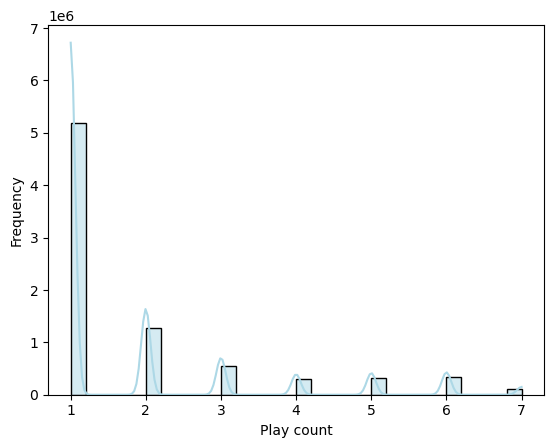

In [31]:
fig, axs = figsize=(8, 8)
sns.histplot(song_data['play_count'], kde=True, 
             bins=int(30), color = 'lightblue', 
             edgecolor='black',
             linewidth=1)
plt.xlabel('Play count')
plt.ylabel('Frequency')
plt.show()

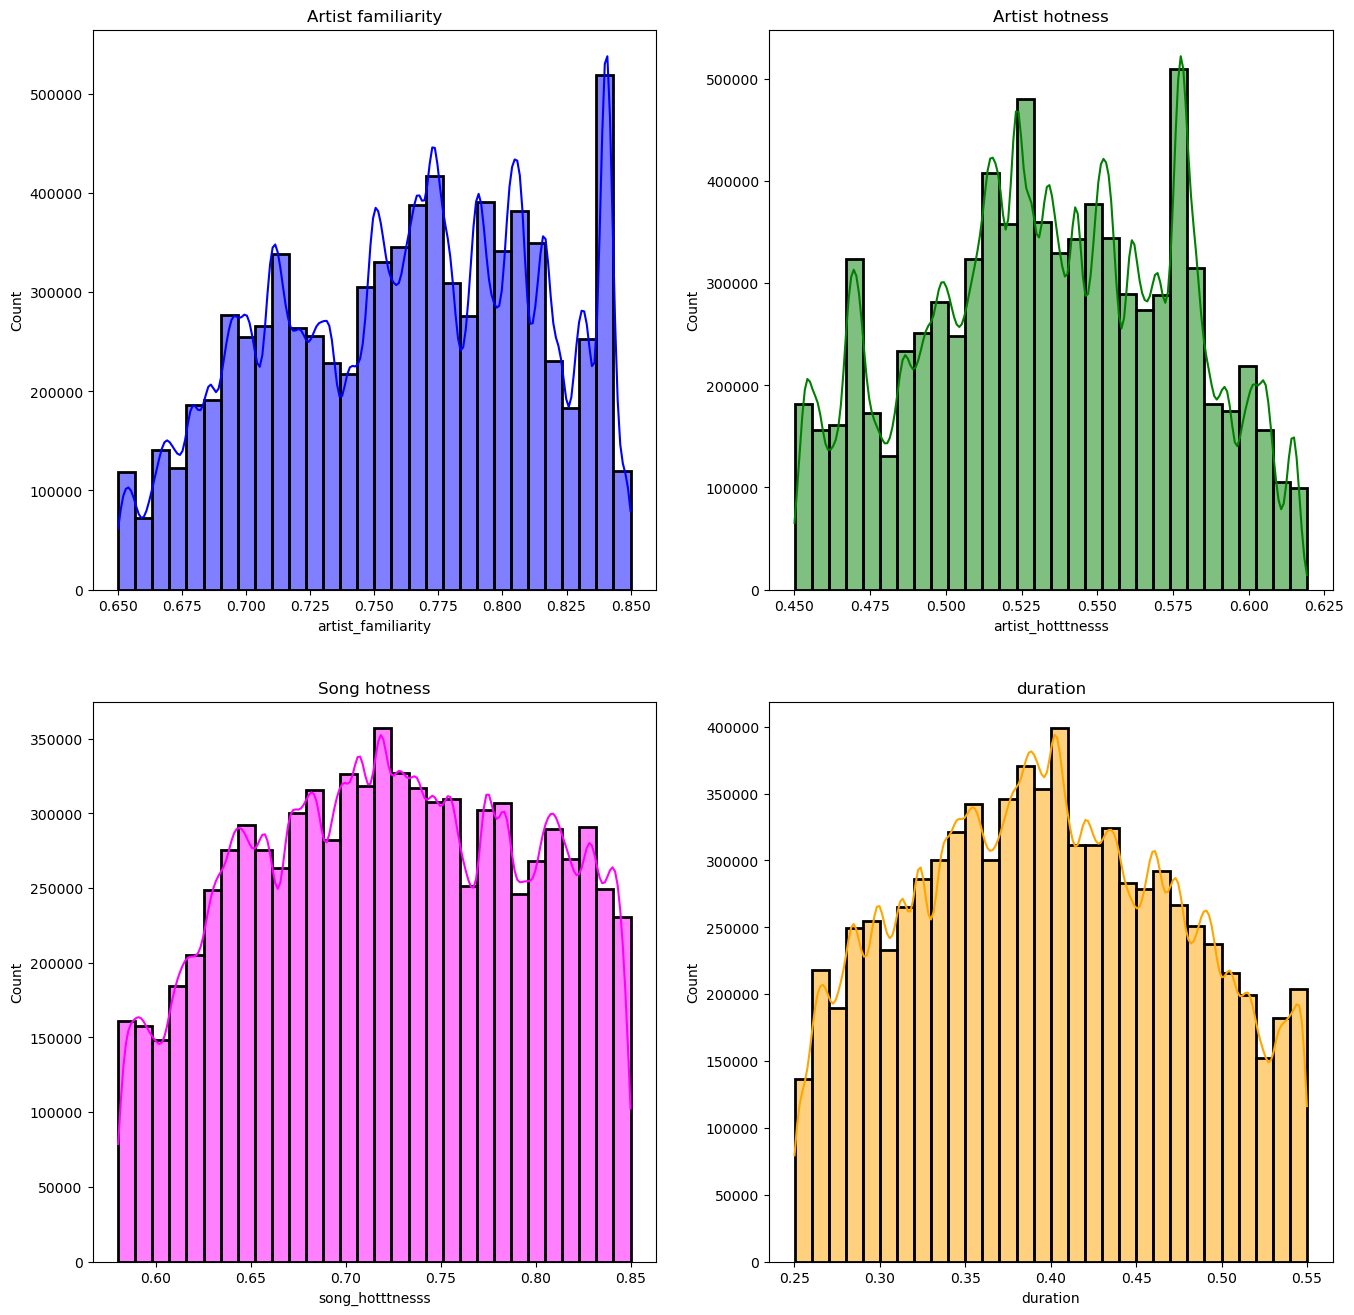

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
sns.histplot(song_data['artist_familiarity'], kde=True, 
             bins=int(30), color = 'blue', 
             edgecolor='black',
             linewidth=2, ax=axs[0][0])
axs[0][0].set_title('Artist familiarity')
sns.histplot(song_data['artist_hotttnesss'], kde=True, 
             bins=int(30), color = 'green', 
             edgecolor='black',
             linewidth=2, ax=axs[0][1])
axs[0][1].set_title('Artist hotness')
sns.histplot(song_data['song_hotttnesss'], kde=True, 
             bins=int(30), color = 'magenta', 
             edgecolor='black',
             linewidth=2, ax=axs[1][0])
axs[1][0].set_title('Song hotness')
sns.histplot(song_data['duration'], kde=True, 
             bins=int(30), color = 'orange', 
             edgecolor='black',
             linewidth=2, ax=axs[1][1])
axs[1][1].set_title('duration')
plt.show()

Text(0.5, 1.0, 'play_count')

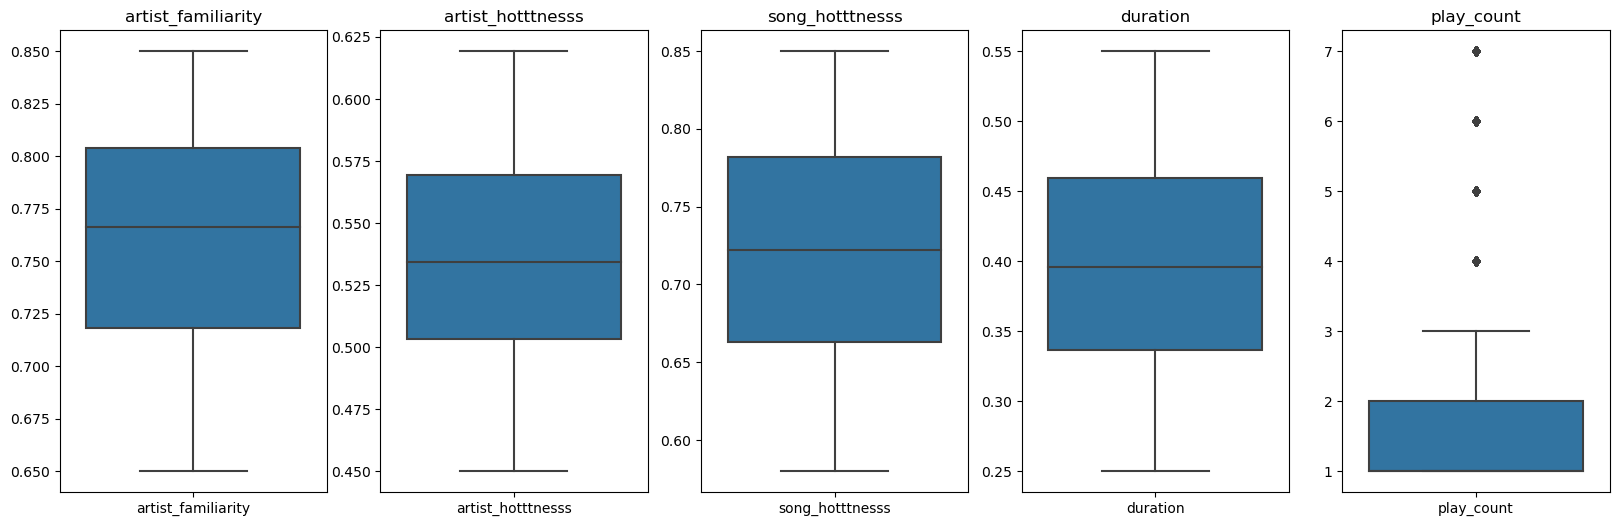

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
sns.boxplot(data=song_data[['artist_familiarity']], ax=axs[0])
axs[0].set_title('artist_familiarity')
sns.boxplot(data=song_data[['artist_hotttnesss']], ax=axs[1])
axs[1].set_title('artist_hotttnesss')
sns.boxplot(data=song_data[['song_hotttnesss']], ax=axs[2])
axs[2].set_title('song_hotttnesss')
sns.boxplot(data=song_data[['duration']], ax=axs[3])
axs[3].set_title('duration')
sns.boxplot(data=song_data[['play_count']], ax=axs[4])
axs[4].set_title('play_count')

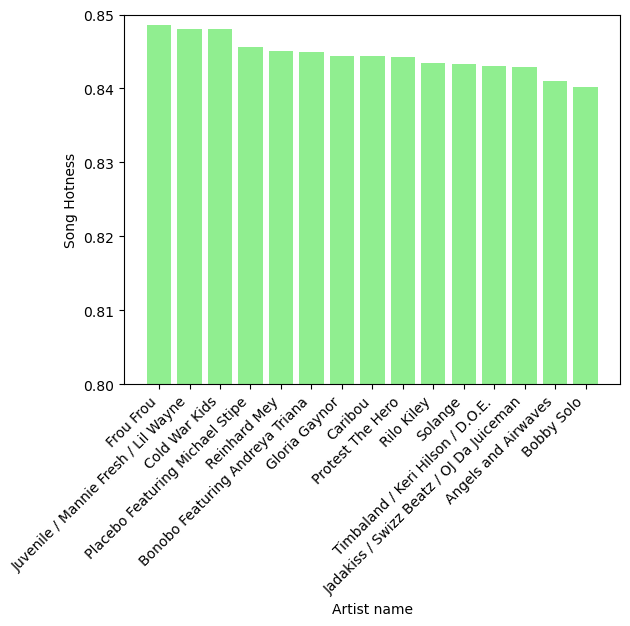

In [34]:
top_albums = song_data.groupby(['artist_name'])['song_hotttnesss'].mean().sort_values(ascending=False)[:15]
plt.ylim(0.8, 0.85)
plt.bar(top_albums.index, top_albums.values, color='lightgreen')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Artist name')
plt.ylabel('Song Hotness')
plt.show()

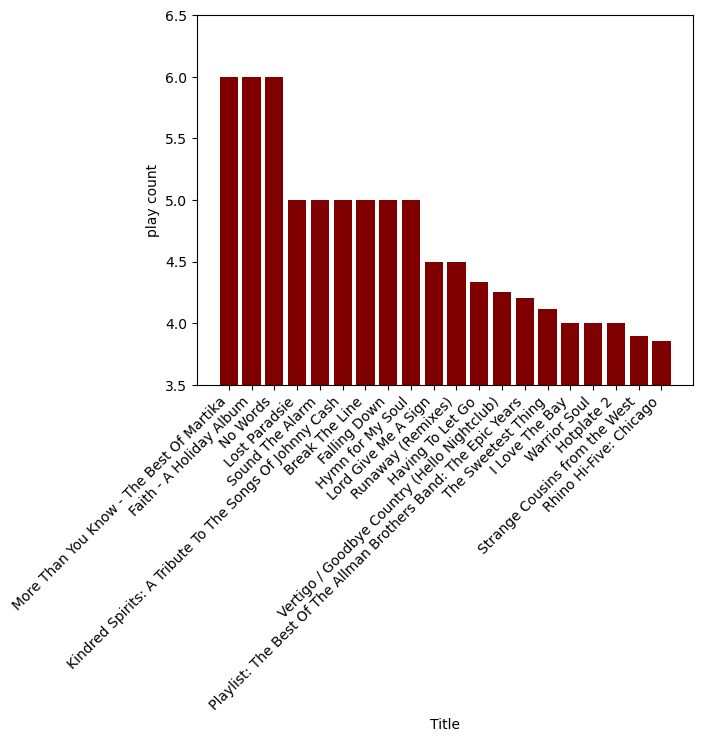

In [35]:
top_artists = song_data.groupby(['release'])['play_count'].mean().sort_values(ascending=False)[:20]
plt.ylim(3.5, 6.5)
plt.bar(top_artists.index, top_artists.values, color='maroon')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Title')
plt.ylabel('play count')
plt.show()

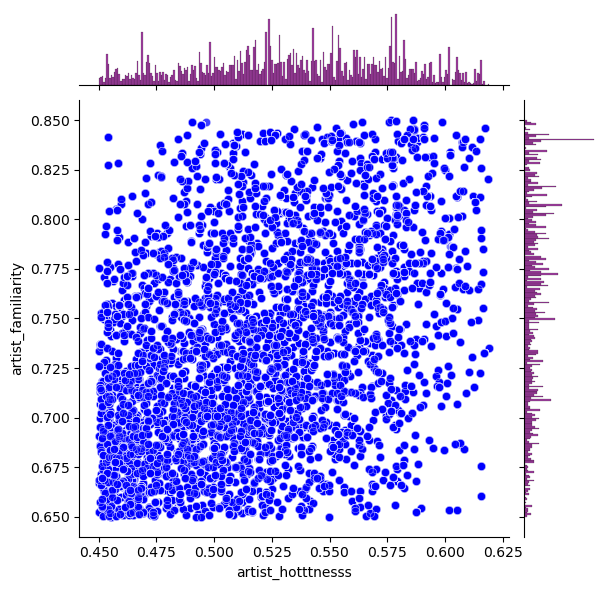

In [36]:
sns.jointplot(x = song_data['artist_hotttnesss'], y = song_data['artist_familiarity'], kind = 'scatter', alpha = 0.5, color = 'blue', marginal_kws = {'color': 'purple'})
plt.show()

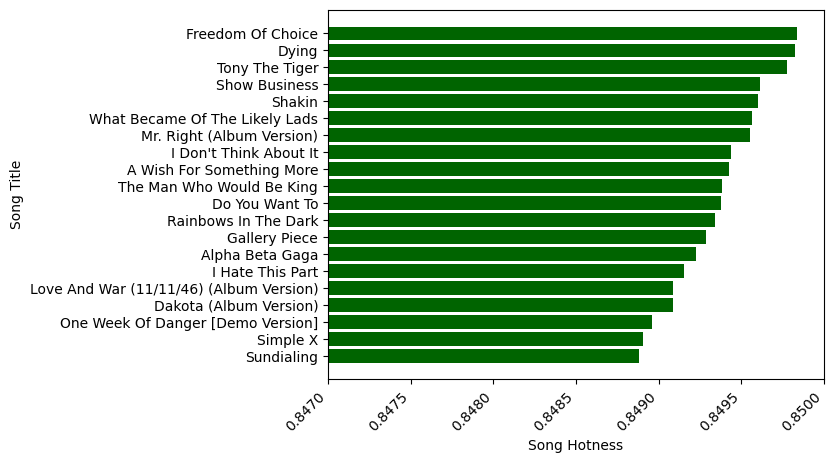

In [37]:
top_songs = song_data.groupby(['title'])['song_hotttnesss'].mean().sort_values(ascending=False)[:20]
plt.gca().invert_yaxis()
plt.xlim(0.847, 0.85)
plt.barh(top_songs.index, top_songs.values, color="darkgreen")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Song Hotness')
plt.ylabel('Song Title')
plt.show()

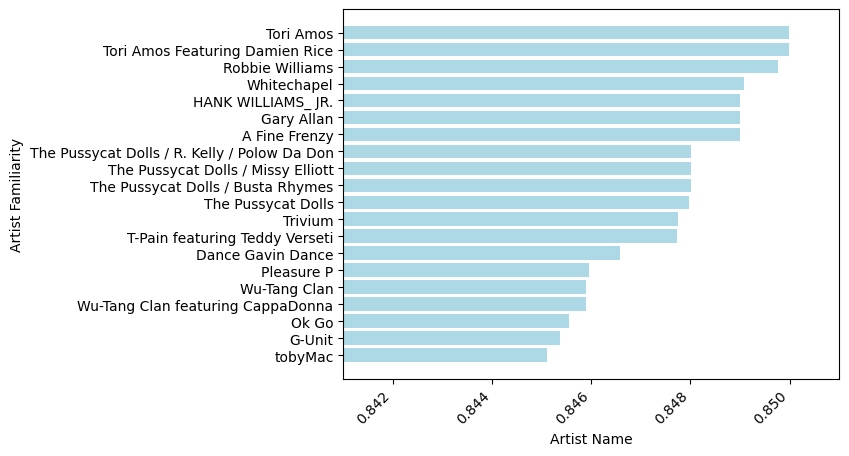

In [38]:
top_artists = song_data.groupby(['artist_name'])['artist_familiarity'].mean().sort_values(ascending=False)[:20]
plt.gca().invert_yaxis()
plt.xlim(0.841, 0.851)
plt.barh(top_artists.index, top_artists.values, color="lightblue")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Artist Name')
plt.ylabel('Artist Familiarity')
plt.show()

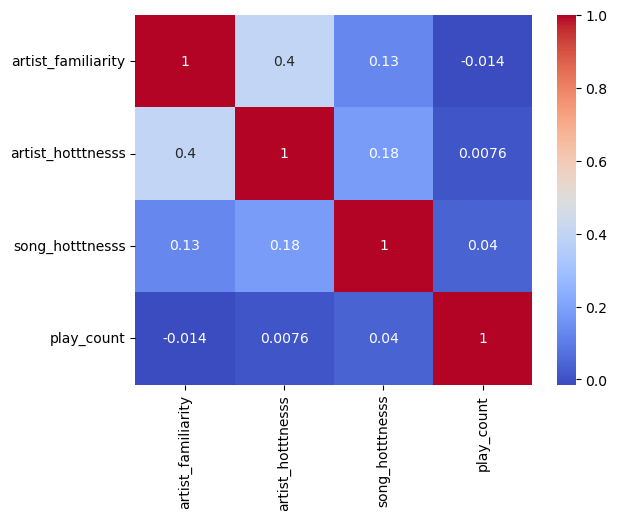

In [39]:
corr = song_data[['artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'play_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [40]:
reader = Reader(rating_scale=(1, 7))
songdata = Dataset.load_from_df(song_data[['user_id', 'song_id', 'play_count']], reader)

In [41]:
train_set, test_set = train_test_split(songdata, test_size=0.1, random_state=42)
svd = SVD(n_factors= 2, n_epochs=20, lr_all= 0.007, reg_all= 0.1, init_mean= 0, init_std_dev= 0.001)
svd.fit(train_set)

In [42]:
predictions = svd.test(test_set)
accuracy.rmse(predictions)

RMSE: 1.3503


1.3503298066719882

In [43]:
trainset = songdata.build_full_trainset()
svdc = SVD(n_factors= 2, n_epochs=20, lr_all= 0.007, reg_all= 0.1, init_mean= 0, init_std_dev= 0.001)
svdc.fit(trainset)
predictions = svdc.test(test_set)

In [44]:
song_data['title'] = song_data['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
song_data['title'] = song_data['title'].apply(lambda x: x.lower())

song_data['artist_name'] = song_data['artist_name'].apply(lambda x: str(x).lower()) # Convert to lowercase
song_data['artist_name'] = song_data['artist_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation

song_data['release'] = song_data['release'].apply(lambda x: str(x).lower()) # Convert to lowercase
song_data['release'] = song_data['release'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation

In [45]:
svd_song_data = song_data
playcount_pred = []
for i in range(len(svd_song_data)):
  playcount_pred.append(svdc.predict(svd_song_data["user_id"][i], svd_song_data["song_id"][i]).est)
svd_song_data['playcount_pred'] = playcount_pred

In [46]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(svd_song_data, test_size=0.1, random_state=42)

In [47]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
target = ['play_count']

train_input = train_data[inputs].copy()
train_target = train_data[target]

In [48]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
target = ['play_count']

test_input = test_data[inputs].copy()
test_target = test_data[target]

In [49]:
text_data = ['artist_name', 'title', 'release']
meta_text = train_data[text_data].copy()

train_input.shape, meta_text.shape

((7267886, 10), (7267886, 3))

In [50]:
test_text_data = ['artist_name', 'title', 'release']
test_meta_text = test_data[test_text_data].copy()

test_input.shape, test_meta_text.shape

((807543, 10), (807543, 3))

In [51]:
meta_text['text'] = meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in meta_text['text']]
emb_size = 30
model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

In [52]:
test_meta_text['text'] = test_meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in test_meta_text['text']]
emb_size = 30
test_model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

In [53]:
text_vector = []
for text in meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_ft.wv:
            vec += model_ft.wv[token]
    text_vector.append(vec)
    
text_vector = np.array(text_vector)
text_vector.shape

(7267886, 30)

In [54]:
test_text_vector = []
for text in test_meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in test_model_ft.wv:
            vec += test_model_ft.wv[token]
    test_text_vector.append(vec)
    
test_text_vector = np.array(test_text_vector)
test_text_vector.shape

(807543, 30)

In [55]:
train_cols = train_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values #'duration'
train_with_meta = np.concatenate((text_vector, train_cols), axis=1)
train_with_meta.shape

(7267886, 35)

In [56]:
test_cols = test_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values #
test_with_meta = np.concatenate((test_text_vector, test_cols), axis=1)
test_with_meta.shape

(807543, 35)

In [57]:
song_col = ['song_id']
user_col = ['user_id']

song_input = train_input[song_col].copy()
user_input = train_input[user_col].copy()
song_input.shape, user_input.shape

((7267886, 1), (7267886, 1))

In [58]:
test_song_input = test_input[song_col].copy()
test_user_input = test_input[user_col].copy()
test_song_input.shape,test_user_input.shape

((807543, 1), (807543, 1))

In [59]:
max_song_id = max(train_input.song_id) 
max_user_id = max(train_input.user_id) 
song_input_dim = 1 
user_input_dim = 1 

meta_text_dim = train_with_meta.shape[1]

max_song_id, max_user_id, song_input_dim, user_input_dim, meta_text_dim

(25991, 888883, 1, 1, 35)

In [60]:
input_song = Input(shape=(song_input_dim,)) 
embedding_layer_songs = Embedding(max_song_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_song)
embedding_output_songs = Flatten()(embedding_layer_songs)

input_user = Input(shape=(user_input_dim,))
embedding_layer_users = Embedding(max_user_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_user)
embedding_output_users = Flatten()(embedding_layer_users)

input_meta = Input(shape=(meta_text_dim,), name='metadata_input')
dense_layer = Dense(64, activation='relu')(input_meta)
metadata_embedding = Dense(10, activation='relu',name='metadata_embedding')(dense_layer)


joining_layer = Concatenate()([embedding_output_songs, embedding_output_users, metadata_embedding])
hidden_layer_1 = Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0))(joining_layer)
hidden_layer_1 = Dense(8, activation='relu', kernel_regularizer=regularizers.L2(0))(hidden_layer_1)

def custom_activation(x):
    return K.clip(x, 0.0, 10.0)
output_layer = Dense(1,activation=custom_activation, kernel_initializer='lecun_uniform')(hidden_layer_1)

model1 = tf.keras.Model([input_song, input_user, input_meta], output_layer)

2023-04-29 02:11:29.841384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 02:11:29.857187: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [61]:
optimizer = Adam(lr=0.001, epsilon = 1e-6, amsgrad=True)
model1.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 metadata_input (InputLayer)    [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        259920      ['input_1[0][0]']                
                                                                                              

In [62]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 1)

history = model1.fit(
  [song_input, user_input, train_with_meta], train_target, 
  batch_size = 512, 
  epochs = 2, 
  verbose = 1,
  callbacks = [early_stopping],
  validation_split=0.1
)

Epoch 1/2
12776/12776 [==============================] - 574s 45ms/step - loss: 1.6667 - root_mean_squared_error: 1.2781 - val_loss: 1.5765 - val_root_mean_squared_error: 1.2495
Epoch 2/2
12776/12776 [==============================] - 634s 50ms/step - loss: 1.5714 - root_mean_squared_error: 1.2462 - val_loss: 1.5674 - val_root_mean_squared_error: 1.2445


In [63]:
pred_nn = model1.predict([test_song_input, test_user_input, test_with_meta])

25236/25236 [==============================] - 142s 6ms/step


In [64]:
target_pc = test_target.values

rmse = np.sqrt(np.mean((pred_nn - target_pc)**2))
rmse

1.2559858549618874

In [65]:
# results visualization